In [37]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa

from matplotlib import pyplot as plt
from sklearn.metrics import log_loss
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, AveragePooling2D, Lambda, Input, Dense, Flatten,

concatenate
from tensorflow.keras.layers import ReLU, LeakyReLU, PReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

## small network for small dataset

In [2]:
def build_nin(activation, shape, classes, alpha=0.3):
    if activation == 'relu':
        activations = [ReLU() for _ in range(13)]

    elif activation == 'leaky_relu':
        activations = [LeakyReLU(alpha=alpha) for _ in range(13)]

    elif activation == 'prelu':
        activations = [PReLU() for _ in range(13)]

    initializer = 'he_uniform'

    input_layer = Input(shape)
    x = Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer=initializer, strides=(1, 1), padding='same')(
        input_layer)
    x = activations[0](x)
    x = Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer=initializer, strides=(1, 1), padding='same')(x)
    x = activations[1](x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # second conv block
    x = Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer=initializer, strides=(1, 1), padding='same')(x)
    x = activations[2](x)
    x = Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer=initializer, strides=(1, 1), padding='same')(x)
    x = activations[3](x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # third conv block
    x = Conv2D(filters=256, kernel_size=(3, 3), kernel_initializer=initializer, strides=(1, 1), padding='same')(x)
    x = activations[4](x)
    x = Conv2D(filters=256, kernel_size=(3, 3), kernel_initializer=initializer, strides=(1, 1), padding='same')(x)
    x = activations[5](x)
    x = Conv2D(filters=256, kernel_size=(1, 1), kernel_initializer=initializer, strides=(1, 1), padding='same')(x)
    x = activations[6](x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # fourth conv block
    x = Conv2D(filters=512, kernel_size=(3, 3), kernel_initializer=initializer, strides=(1, 1), padding='same')(x)
    x = activations[7](x)
    x = Conv2D(filters=512, kernel_size=(3, 3), kernel_initializer=initializer, strides=(1, 1), padding='same')(x)
    x = activations[8](x)
    x = Conv2D(filters=512, kernel_size=(1, 1), kernel_initializer=initializer, strides=(1, 1), padding='same')(x)
    x = activations[9](x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # fifth conv block
    x = Conv2D(filters=512, kernel_size=(3, 3), kernel_initializer=initializer, strides=(1, 1), padding='same')(x)
    x = activations[10](x)
    x = Conv2D(filters=512, kernel_size=(3, 3), kernel_initializer=initializer, strides=(1, 1), padding='same')(x)
    x = activations[11](x)
    x = Conv2D(filters=512, kernel_size=(1, 1), kernel_initializer=initializer, strides=(1, 1), padding='same')(x)
    x = activations[12](x)
    x = AveragePooling2D(pool_size=(5, 5))(x)
    x = Flatten()(x)
    output_layer = Dense(classes, activation=tf.nn.softmax)(x)

    model = Model(input_layer, output_layer)

    return model

In [3]:
def inception(x, filters, projection, activations, initializer='he_uniform', classes=None, aux=False, name=None,
              aux_name=None):
    f_1x1, f_3x3, f_3x3_reduce, f_5x5, f_5x5_reduce = filters
    a1, a2, a3, a4, a5, a6 = activations

    x1 = Conv2D(filters=f_1x1, kernel_size=(1, 1), kernel_initializer=initializer, strides=(1, 1), padding='same')(x)
    x1 = a1(x1)
    x3_reducer = Conv2D(filters=f_3x3_reduce, kernel_initializer=initializer, kernel_size=(1, 1), strides=(1, 1),
                        padding='same')(x)
    x3_reducer = a2(x3_reducer)
    x5_reducer = Conv2D(filters=f_5x5_reduce, kernel_initializer=initializer, kernel_size=(1, 1), strides=(1, 1),
                        padding='same')(x)
    x5_reducer = a3(x5_reducer)
    pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)

    x3 = Conv2D(filters=f_3x3, kernel_size=(3, 3), kernel_initializer=initializer, strides=(1, 1), padding='same')(
        x3_reducer)
    x3 = a4(x3)
    x5 = Conv2D(filters=f_5x5, kernel_size=(5, 5), kernel_initializer=initializer, strides=(1, 1), padding='same')(
        x5_reducer)
    x5 = a5(x5)
    proj = Conv2D(filters=projection, kernel_size=(1, 1), kernel_initializer=initializer, strides=(1, 1),
                  padding='same')(pool)
    proj = a6(proj)

    x = concatenate([x1, x3, x5, proj], axis=3, name=name)

    return x


def build_dw(activation, shape, classes, alpha=0.3):
    if activation == 'relu':
        activations_batch = [[ReLU() for _ in range(6)] for _ in range(9)]
        activations_single = [ReLU() for _ in range(3)]

    elif activation == 'leaky_relu':
        activations_batch = [[LeakyReLU(alpha=alpha) for _ in range(6)] for _ in range(9)]
        activations_single = [LeakyReLU(alpha=alpha) for _ in range(3)]

    elif activation == 'prelu':
        activations_batch = [[PReLU() for _ in range(6)] for _ in range(9)]
        activations_single = [PReLU() for _ in range(3)]

    initializer = 'he_uniform'

    input_layer = Input(shape)
    x = Conv2D(filters=64, kernel_size=(7, 7), kernel_initializer=initializer, strides=(2, 2), padding='same')(
        input_layer)
    x = activations_single[0](x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = Conv2D(filters=64, kernel_size=(1, 1), kernel_initializer=initializer, strides=(1, 1), padding='same')(x)
    x = activations_single[1](x)
    x = Conv2D(filters=192, kernel_size=(3, 3), kernel_initializer=initializer, strides=(1, 1), padding='same')(x)
    x = activations_single[2](x)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception(x, [64, 128, 96, 32, 16], projection=32, activations=activations_batch[0], name='inception_3a')
    x = inception(x, [128, 192, 128, 96, 32], projection=64, activations=activations_batch[1], name='inception_3b')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = inception(x, [192, 208, 96, 48, 16], projection=64, activations=activations_batch[2], name='inception_4a')
    x = inception(x, [160, 224, 112, 64, 24], projection=64, activations=activations_batch[3], name='inception_4b')
    x = inception(x, [128, 256, 128, 64, 24], projection=64, activations=activations_batch[4], name='inception_4c')
    x = inception(x, [112, 288, 144, 64, 32], projection=64, activations=activations_batch[5], name='inception_4d')
    x = inception(x, [256, 320, 160, 128, 32], projection=128, activations=activations_batch[6], name='inception_4e')

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception(x, [256, 320, 160, 128, 32], projection=128, activations=activations_batch[7], name='inception_5a')
    x = inception(x, [384, 384, 192, 128, 48], projection=128, activations=activations_batch[8], name='inception_5b')
    x = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(x)
    x = Dropout(rate=0.4)(x)
    x = Flatten()(x)
    output_layer = Dense(classes, activation=tf.nn.softmax)(x)

    model = Model(input_layer, output_layer)

    return model

In [4]:
model_r = build_nin(activation='relu', shape=(96, 96, 3), classes=400)
model_lr_1 = build_nin(activation='leaky_relu', shape=(96, 96, 3), classes=400, alpha=1)
model_lr_2 = build_nin(activation='leaky_relu', shape=(96, 96, 3), classes=400, alpha=10)
model_pr = build_nin(activation='prelu', shape=(96, 96, 3), classes=400)

model_dw_r = build_dw(activation='relu', shape=(96, 96, 3), classes=400)
model_dw_lr_1 = build_dw(activation='leaky_relu', shape=(96, 96, 3), classes=400, alpha=1)
model_dw_lr_2 = build_dw(activation='leaky_relu', shape=(96, 96, 3), classes=400, alpha=10)
model_dw_pr = build_dw(activation='prelu', shape=(96, 96, 3), classes=400)

2022-04-11 18:49:08.741531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 18:49:08.831646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 18:49:08.832464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 18:49:08.833635: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
# train_meta = pd.read_csv('../input/humpback-whale-identification/train.csv')
# train_meta

In [6]:
generator = ImageDataGenerator(rescale=1 / 255.)

train_batch = generator.flow_from_directory(directory='../input/100-bird-species/train/',
                                            target_size=(96, 96))

valid_batch = generator.flow_from_directory(directory='../input/100-bird-species/valid/',
                                            target_size=(96, 96))

Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.


In [7]:
model_r.compile(optimizer=Adam(),
                loss=categorical_crossentropy,
                metrics=['accuracy'])

model_lr_1.compile(optimizer=Adam(),
                   loss=categorical_crossentropy,
                   metrics=['accuracy'])

model_lr_2.compile(optimizer=Adam(),
                   loss=categorical_crossentropy,
                   metrics=['accuracy'])

model_pr.compile(optimizer=Adam(),
                 loss=categorical_crossentropy,
                 metrics=['accuracy'])

model_dw_r.compile(optimizer=Adam(),
                   loss=categorical_crossentropy,
                   metrics=['accuracy'])

model_dw_lr_1.compile(optimizer=Adam(),
                      loss=categorical_crossentropy,
                      metrics=['accuracy'])

model_dw_lr_2.compile(optimizer=Adam(),
                      loss=categorical_crossentropy,
                      metrics=['accuracy'])

model_dw_pr.compile(optimizer=Adam(),
                    loss=categorical_crossentropy,
                    metrics=['accuracy'])

In [8]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=10)

In [9]:
history_r = model_r.fit(train_batch,
                        epochs=50,
                        validation_data=valid_batch,
                        steps_per_epoch=256,
                        callbacks=[reduce_lr])

2022-04-11 18:49:20.068533: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-11 18:49:21.849652: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


256/256 [==============================] - 62s 210ms/step - loss: 6.0024 - accuracy: 0.0034 - val_loss: 5.9937 - val_accuracy: 0.0025
Epoch 2/50
256/256 [==============================] - 44s 172ms/step - loss: 5.9897 - accuracy: 0.0045 - val_loss: 5.9937 - val_accuracy: 0.0025
Epoch 3/50
256/256 [==============================] - 42s 162ms/step - loss: 5.9850 - accuracy: 0.0044 - val_loss: 5.9970 - val_accuracy: 0.0025
Epoch 4/50
256/256 [==============================] - 38s 148ms/step - loss: 5.9857 - accuracy: 0.0042 - val_loss: 5.9974 - val_accuracy: 0.0025
Epoch 5/50
256/256 [==============================] - 35s 136ms/step - loss: 5.9854 - accuracy: 0.0043 - val_loss: 5.9978 - val_accuracy: 0.0025
Epoch 6/50
256/256 [==============================] - 33s 130ms/step - loss: 5.9830 - accuracy: 0.0051 - val_loss: 6.0008 - val_accuracy: 0.0025
Epoch 7/50
256/256 [==============================] - 31s 122ms/step - loss: 5.9853 - accuracy: 0.0033 - val_loss: 5.9993 - val_accuracy: 0.0

In [10]:
# model_r.save('model_r.hdf5')
pd.DataFrame(history_r.history).to_pickle('history_r.pkl')

In [11]:
history_lr1 = model_lr_1.fit(train_batch,
                             epochs=50,
                             validation_data=valid_batch,
                             steps_per_epoch=256,
                             callbacks=[reduce_lr])

Epoch 1/50
256/256 [==============================] - 25s 93ms/step - loss: 1127.2429 - accuracy: 0.0044 - val_loss: 9.4973 - val_accuracy: 0.0100
Epoch 2/50
256/256 [==============================] - 24s 96ms/step - loss: 8.0957 - accuracy: 0.0109 - val_loss: 7.4586 - val_accuracy: 0.0180
Epoch 3/50
256/256 [==============================] - 23s 90ms/step - loss: 6.6942 - accuracy: 0.0210 - val_loss: 6.2000 - val_accuracy: 0.0340
Epoch 4/50
256/256 [==============================] - 23s 88ms/step - loss: 6.0504 - accuracy: 0.0343 - val_loss: 5.8267 - val_accuracy: 0.0395
Epoch 5/50
256/256 [==============================] - 23s 89ms/step - loss: 5.6859 - accuracy: 0.0416 - val_loss: 5.6417 - val_accuracy: 0.0500
Epoch 6/50
256/256 [==============================] - 27s 104ms/step - loss: 5.3504 - accuracy: 0.0586 - val_loss: 5.0685 - val_accuracy: 0.0815
Epoch 7/50
256/256 [==============================] - 22s 87ms/step - loss: 5.1407 - accuracy: 0.0712 - val_loss: 4.9057 - val_accur

In [12]:
# model_lr_1.save('model_lr_1.hdf5')
pd.DataFrame(history_lr1.history).to_pickle('history_lr1.pkl')

In [13]:
history_lr2 = model_lr_2.fit(train_batch,
                             epochs=50,
                             validation_data=valid_batch,
                             steps_per_epoch=256,
                             callbacks=[reduce_lr])

Epoch 1/50
256/256 [==============================] - 23s 87ms/step - loss: 172427919360.0000 - accuracy: 0.0035 - val_loss: 376936256.0000 - val_accuracy: 0.0050
Epoch 2/50
256/256 [==============================] - 23s 88ms/step - loss: 259144976.0000 - accuracy: 0.0046 - val_loss: 180362944.0000 - val_accuracy: 0.0040
Epoch 3/50
256/256 [==============================] - 22s 87ms/step - loss: 143183328.0000 - accuracy: 0.0048 - val_loss: 116095704.0000 - val_accuracy: 0.0045
Epoch 4/50
256/256 [==============================] - 26s 101ms/step - loss: 95996888.0000 - accuracy: 0.0051 - val_loss: 79602376.0000 - val_accuracy: 0.0015
Epoch 5/50
256/256 [==============================] - 21s 83ms/step - loss: 71286960.0000 - accuracy: 0.0057 - val_loss: 63614416.0000 - val_accuracy: 0.0040
Epoch 6/50
256/256 [==============================] - 21s 81ms/step - loss: 53080860.0000 - accuracy: 0.0070 - val_loss: 47605376.0000 - val_accuracy: 0.0060
Epoch 7/50
256/256 [======================

In [14]:
# model_lr_2.save('model_lr_2.hdf5')
pd.DataFrame(history_lr2.history).to_pickle('history_lr2.pkl')

In [15]:
history_pr = model_pr.fit(train_batch,
                          epochs=50,
                          validation_data=valid_batch,
                          steps_per_epoch=256,
                          callbacks=[reduce_lr])

Epoch 1/50
256/256 [==============================] - 26s 94ms/step - loss: 6.0012 - accuracy: 0.0033 - val_loss: 5.9926 - val_accuracy: 0.0025
Epoch 2/50
256/256 [==============================] - 26s 101ms/step - loss: 5.9900 - accuracy: 0.0033 - val_loss: 5.9947 - val_accuracy: 0.0025
Epoch 3/50
256/256 [==============================] - 26s 100ms/step - loss: 5.9884 - accuracy: 0.0033 - val_loss: 5.9951 - val_accuracy: 0.0025
Epoch 4/50
256/256 [==============================] - 33s 130ms/step - loss: 5.9882 - accuracy: 0.0031 - val_loss: 5.9950 - val_accuracy: 0.0025
Epoch 5/50
256/256 [==============================] - 26s 102ms/step - loss: 5.9858 - accuracy: 0.0037 - val_loss: 5.9974 - val_accuracy: 0.0025
Epoch 6/50
256/256 [==============================] - 26s 102ms/step - loss: 5.9862 - accuracy: 0.0033 - val_loss: 5.9971 - val_accuracy: 0.0025
Epoch 7/50
256/256 [==============================] - 25s 97ms/step - loss: 5.9841 - accuracy: 0.0035 - val_loss: 5.9996 - val_accu

In [16]:
# model_pr.save('model_pr.hdf5')
pd.DataFrame(history_pr.history).to_pickle('history_pr.pkl')

In [17]:
history_dw_r = model_dw_r.fit(train_batch,
                              epochs=50,
                              validation_data=valid_batch,
                              steps_per_epoch=256,
                              callbacks=[reduce_lr])

Epoch 1/50
256/256 [==============================] - 24s 80ms/step - loss: 5.9972 - accuracy: 0.0032 - val_loss: 5.9938 - val_accuracy: 0.0025
Epoch 2/50
256/256 [==============================] - 21s 80ms/step - loss: 5.9894 - accuracy: 0.0033 - val_loss: 5.9953 - val_accuracy: 0.0025
Epoch 3/50
256/256 [==============================] - 20s 79ms/step - loss: 5.9894 - accuracy: 0.0042 - val_loss: 5.9947 - val_accuracy: 0.0025
Epoch 4/50
256/256 [==============================] - 20s 79ms/step - loss: 5.9874 - accuracy: 0.0055 - val_loss: 5.9981 - val_accuracy: 0.0025
Epoch 5/50
256/256 [==============================] - 20s 77ms/step - loss: 5.9875 - accuracy: 0.0044 - val_loss: 5.9959 - val_accuracy: 0.0025
Epoch 6/50
256/256 [==============================] - 21s 81ms/step - loss: 5.9867 - accuracy: 0.0040 - val_loss: 5.9966 - val_accuracy: 0.0025
Epoch 7/50
256/256 [==============================] - 19s 75ms/step - loss: 5.9838 - accuracy: 0.0046 - val_loss: 5.9997 - val_accuracy:

In [18]:
pd.DataFrame(history_dw_r.history).to_pickle('history_dw_r.pkl')

In [19]:
history_dw_lr1 = model_dw_lr_1.fit(train_batch,
                                   epochs=50,
                                   validation_data=valid_batch,
                                   steps_per_epoch=256,
                                   callbacks=[reduce_lr])

Epoch 1/50
256/256 [==============================] - 23s 81ms/step - loss: 50.0319 - accuracy: 0.0067 - val_loss: 8.0930 - val_accuracy: 0.0165
Epoch 2/50
256/256 [==============================] - 20s 78ms/step - loss: 8.3204 - accuracy: 0.0182 - val_loss: 6.2851 - val_accuracy: 0.0310
Epoch 3/50
256/256 [==============================] - 20s 79ms/step - loss: 6.6160 - accuracy: 0.0337 - val_loss: 5.3788 - val_accuracy: 0.0540
Epoch 4/50
256/256 [==============================] - 19s 76ms/step - loss: 5.8492 - accuracy: 0.0530 - val_loss: 5.1943 - val_accuracy: 0.0590
Epoch 5/50
256/256 [==============================] - 20s 77ms/step - loss: 5.3859 - accuracy: 0.0706 - val_loss: 4.5088 - val_accuracy: 0.1080
Epoch 6/50
256/256 [==============================] - 20s 78ms/step - loss: 5.1026 - accuracy: 0.0884 - val_loss: 4.4594 - val_accuracy: 0.1235
Epoch 7/50
256/256 [==============================] - 20s 78ms/step - loss: 4.8229 - accuracy: 0.1086 - val_loss: 4.1861 - val_accuracy

In [20]:
pd.DataFrame(history_dw_lr1.history).to_pickle('history_dw_lr1.pkl')

In [21]:
history_dw_lr2 = model_dw_lr_2.fit(train_batch,
                                   epochs=50,
                                   validation_data=valid_batch,
                                   steps_per_epoch=256,
                                   callbacks=[reduce_lr])

Epoch 1/50
256/256 [==============================] - 23s 80ms/step - loss: 98743248050192384.0000 - accuracy: 0.0035 - val_loss: 173736091189248.0000 - val_accuracy: 0.0025
Epoch 2/50
256/256 [==============================] - 19s 75ms/step - loss: 157368356700160.0000 - accuracy: 0.0029 - val_loss: 70196551221248.0000 - val_accuracy: 0.0020
Epoch 3/50
256/256 [==============================] - 20s 78ms/step - loss: 78208938541056.0000 - accuracy: 0.0023 - val_loss: 37230613626880.0000 - val_accuracy: 0.0035
Epoch 4/50
256/256 [==============================] - 20s 77ms/step - loss: 45551395536896.0000 - accuracy: 0.0013 - val_loss: 24145551163392.0000 - val_accuracy: 0.0030
Epoch 5/50
256/256 [==============================] - 19s 75ms/step - loss: 30568425193472.0000 - accuracy: 0.0033 - val_loss: 16613263802368.0000 - val_accuracy: 0.0020
Epoch 6/50
256/256 [==============================] - 20s 78ms/step - loss: 21655487250432.0000 - accuracy: 0.0040 - val_loss: 12769640316928.000

In [22]:
pd.DataFrame(history_dw_lr2.history).to_pickle('history_dw_lr2.pkl')

In [23]:
history_dw_pr = model_dw_pr.fit(train_batch,
                                epochs=50,
                                validation_data=valid_batch,
                                steps_per_epoch=256,
                                callbacks=[reduce_lr])

Epoch 1/50
256/256 [==============================] - 28s 88ms/step - loss: 5.9982 - accuracy: 0.0042 - val_loss: 5.9945 - val_accuracy: 0.0025
Epoch 2/50
256/256 [==============================] - 22s 84ms/step - loss: 5.9878 - accuracy: 0.0042 - val_loss: 5.9947 - val_accuracy: 0.0025
Epoch 3/50
256/256 [==============================] - 22s 85ms/step - loss: 5.9870 - accuracy: 0.0037 - val_loss: 5.9991 - val_accuracy: 0.0025
Epoch 4/50
256/256 [==============================] - 21s 83ms/step - loss: 5.9864 - accuracy: 0.0034 - val_loss: 5.9971 - val_accuracy: 0.0025
Epoch 5/50
256/256 [==============================] - 22s 86ms/step - loss: 5.9862 - accuracy: 0.0034 - val_loss: 5.9990 - val_accuracy: 0.0025
Epoch 6/50
256/256 [==============================] - 21s 83ms/step - loss: 5.9839 - accuracy: 0.0042 - val_loss: 5.9991 - val_accuracy: 0.0025
Epoch 7/50
256/256 [==============================] - 21s 82ms/step - loss: 5.9859 - accuracy: 0.0042 - val_loss: 5.9974 - val_accuracy:

In [24]:
pd.DataFrame(history_dw_pr.history).to_pickle('history_dw_pr.pkl')

## Evaluation

In [52]:
ds_1_history_r = pd.read_pickle('emperical test/DS_1/he_init/history_r.pkl')
ds_1_history_lr1 = pd.read_pickle('emperical test/DS_1/he_init/history_lr1.pkl')
ds_1_history_lr2 = pd.read_pickle('emperical test/DS_1/he_init/history_lr2.pkl')
ds_1_history_pr = pd.read_pickle('emperical test/DS_1/he_init/history_pr.pkl')
ds_1_history_dw_r = pd.read_pickle('emperical test/DS_1/he_init/history_dw_r.pkl')
ds_1_history_dw_lr1 = pd.read_pickle('emperical test/DS_1/he_init/history_dw_lr1.pkl')
ds_1_history_dw_lr2 = pd.read_pickle('emperical test/DS_1/he_init/history_dw_lr2.pkl')
ds_1_history_dw_pr = pd.read_pickle('emperical test/DS_1/he_init/history_dw_pr.pkl')

ds_2_history_r = pd.read_pickle('emperical test/DS_2/history_r.pkl')
ds_2_history_lr1 = pd.read_pickle('emperical test/DS_2/history_lr1.pkl')
ds_2_history_lr2 = pd.read_pickle('emperical test/DS_2/history_lr2.pkl')
ds_2_history_pr = pd.read_pickle('emperical test/DS_2/history_pr.pkl')
ds_2_history_dw_r = pd.read_pickle('emperical test/DS_2/history_dw_r.pkl')
ds_2_history_dw_lr1 = pd.read_pickle('emperical test/DS_2/history_dw_lr1.pkl')
ds_2_history_dw_lr2 = pd.read_pickle('emperical test/DS_2/history_dw_lr2.pkl')
ds_2_history_dw_pr = pd.read_pickle('emperical test/DS_2/history_dw_pr.pkl')

ds_3_history_r = pd.read_pickle('emperical test/DS_3/history_r.pkl')
ds_3_history_lr1 = pd.read_pickle('emperical test/DS_3/history_lr1.pkl')
ds_3_history_lr2 = pd.read_pickle('emperical test/DS_3/history_lr2.pkl')
ds_3_history_pr = pd.read_pickle('emperical test/DS_3/history_pr.pkl')
ds_3_history_dw_r = pd.read_pickle('emperical test/DS_3/history_dw_r.pkl')
ds_3_history_dw_lr1 = pd.read_pickle('emperical test/DS_3/history_dw_lr1.pkl')
ds_3_history_dw_lr2 = pd.read_pickle('emperical test/DS_3/history_dw_lr2.pkl')
ds_3_history_dw_pr = pd.read_pickle('emperical test/DS_3/history_dw_pr.pkl')

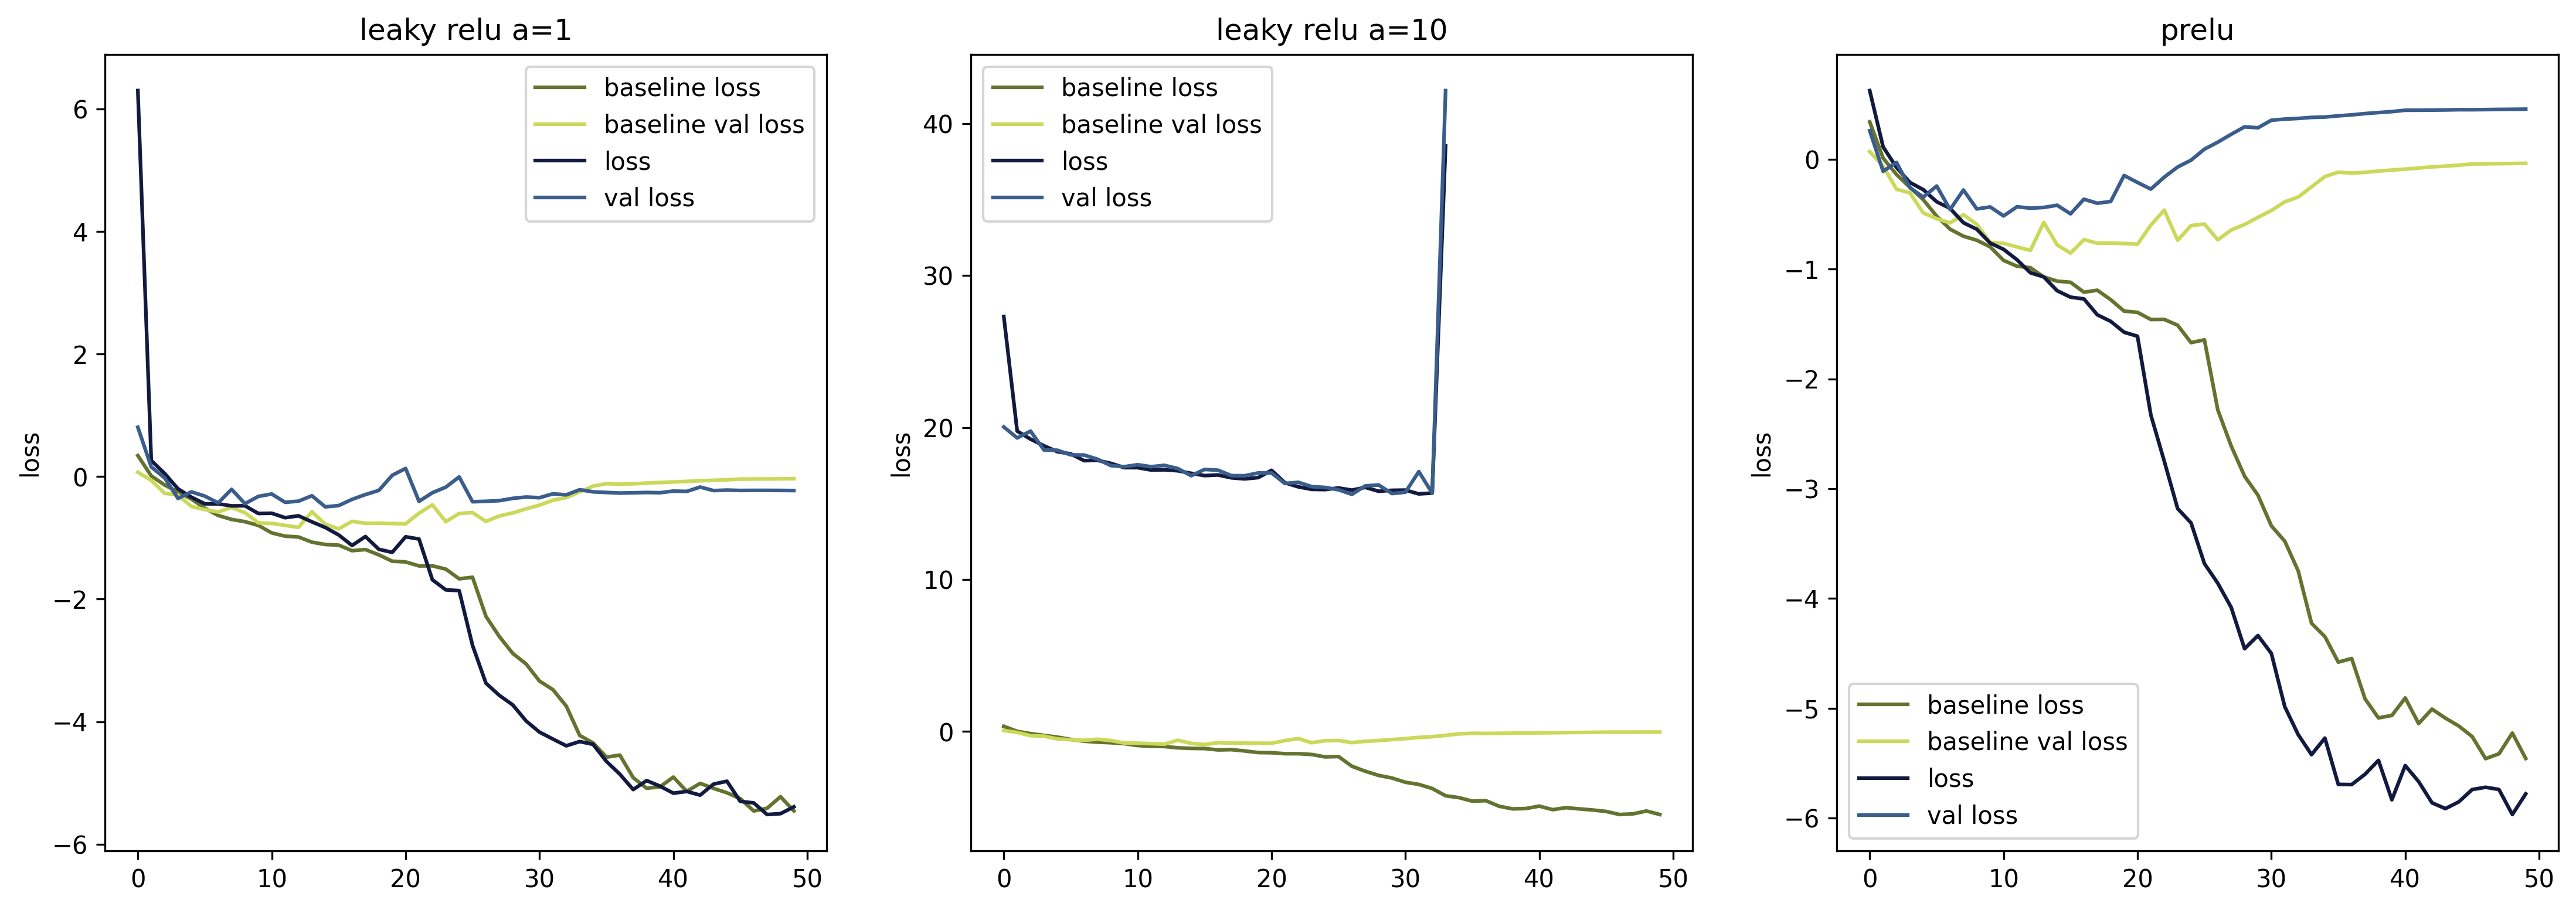

In [44]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=[18, 6], dpi=300)
act = ['leaky relu a=1', 'leaky relu a=10', 'prelu']
ds1 = [ds_1_history_lr1, ds_1_history_lr2, ds_1_history_pr]
ds2 = [ds_2_history_lr1, ds_2_history_lr2, ds_2_history_pr]
ds3 = [ds_3_history_lr1, ds_3_history_lr2, ds_3_history_pr]

for i in range(3):
    sns.lineplot(x=range(len(ds_1_history_r)), y=np.log(ds_1_history_r.loss), ax=axes[i], color='#64732F', label='baseline loss')
    sns.lineplot(x=range(len(ds_1_history_r)), y=np.log(ds_1_history_r.val_loss), ax=axes[i], color='#CAD959', label='baseline val loss')
    sns.lineplot(x=range(len(ds1[i])), y=np.log(ds1[i].loss), ax=axes[i], color='#131A40', label='loss')
    sns.lineplot(x=range(len(ds1[i])), y=np.log(ds1[i].val_loss), ax=axes[i], color='#3A5D8C', label='val loss')
    axes[i].set_title(act[i])

plt.savefig('../../images/activation/emperical evaluation/ds_1_activation_eval.jpg')
plt.show()

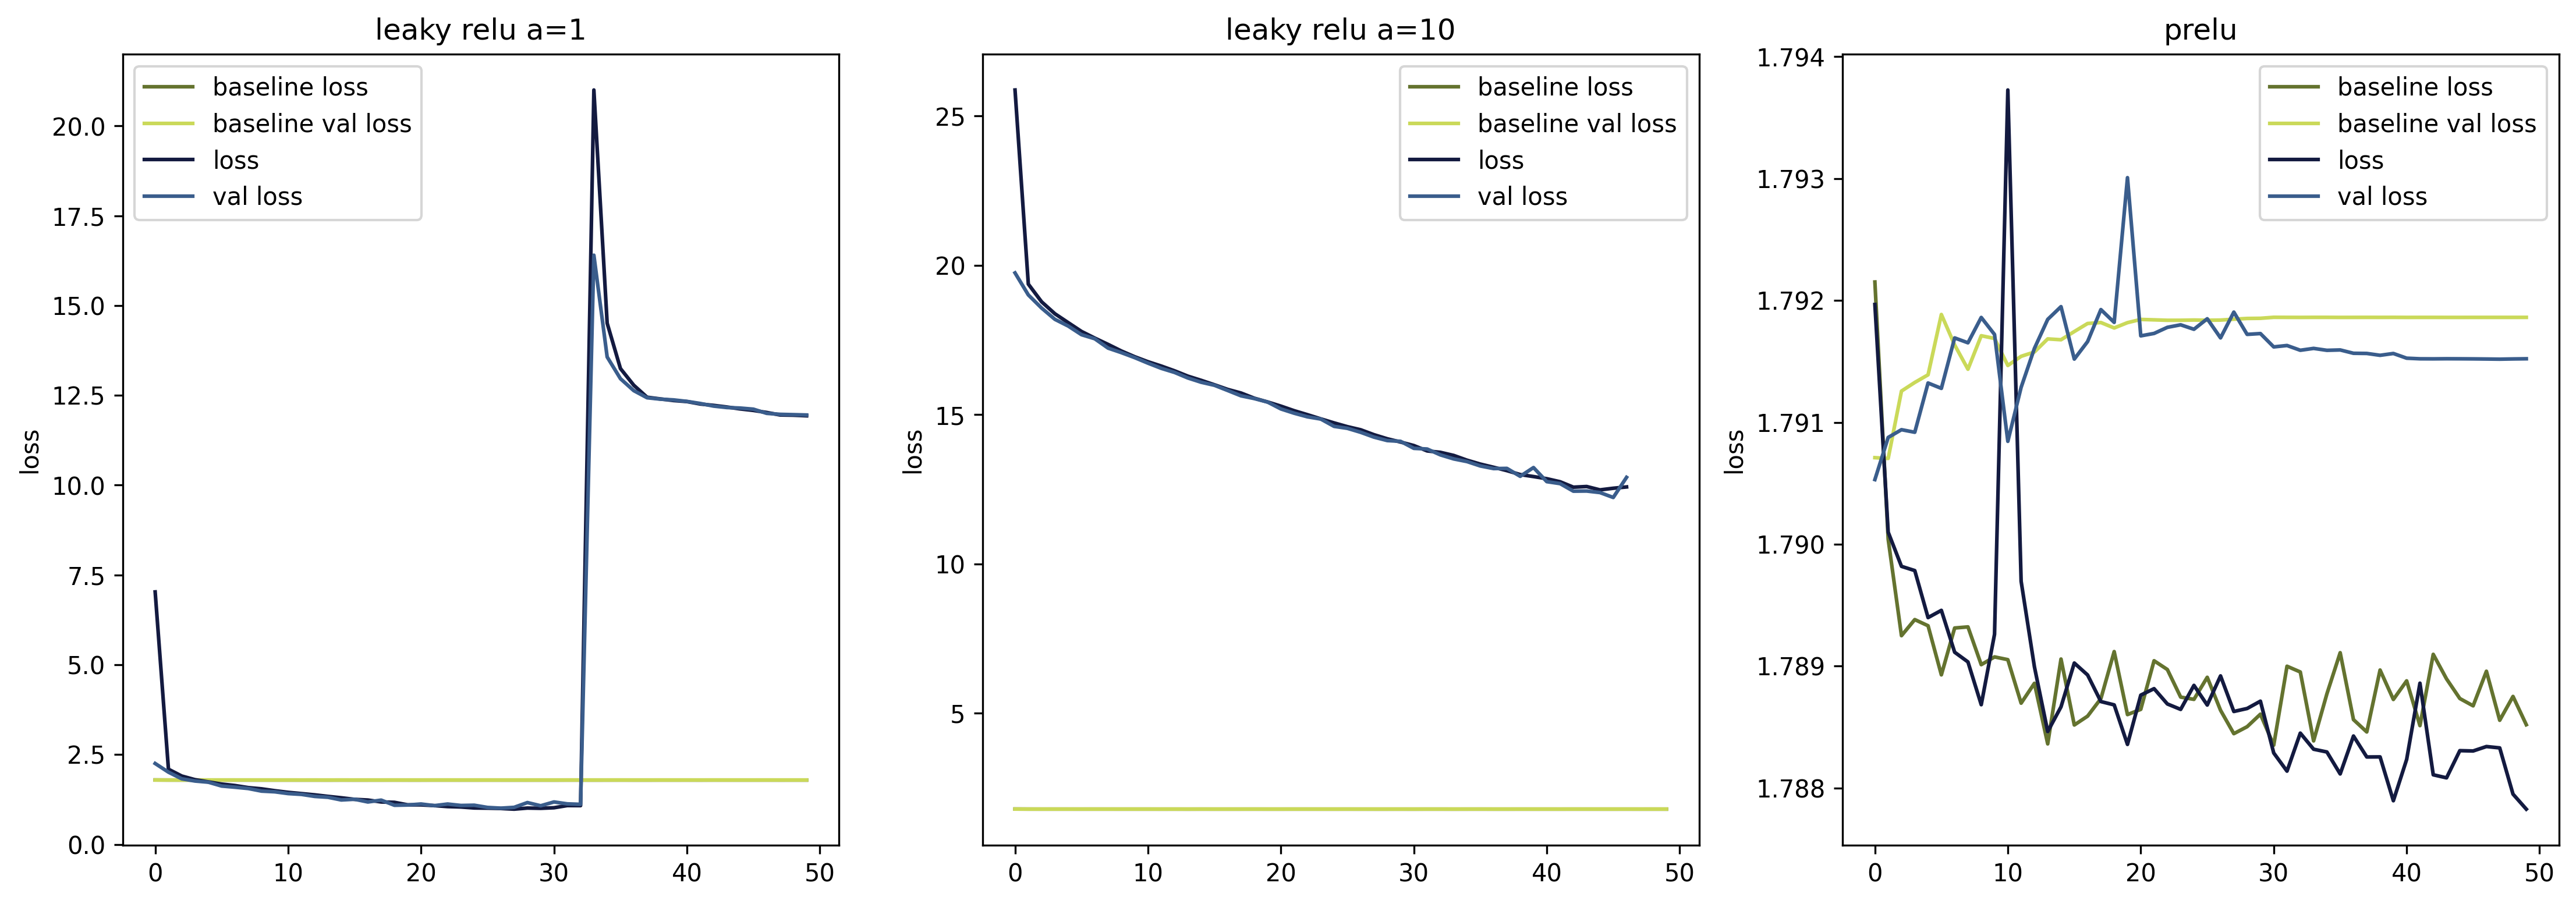

In [54]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=[18, 6], dpi=300)
act = ['leaky relu a=1', 'leaky relu a=10', 'prelu']

for i in range(3):
    sns.lineplot(x=range(len(ds_2_history_r)), y=np.log(ds_2_history_r.loss), ax=axes[i], color='#64732F', label='baseline loss')
    sns.lineplot(x=range(len(ds_2_history_r)), y=np.log(ds_2_history_r.val_loss), ax=axes[i], color='#CAD959', label='baseline val loss')
    sns.lineplot(x=range(len(ds2[i])), y=np.log(ds2[i].loss), ax=axes[i], color='#131A40', label='loss')
    sns.lineplot(x=range(len(ds2[i])), y=np.log(ds2[i].val_loss), ax=axes[i], color='#3A5D8C', label='val loss')
    axes[i].set_title(act[i])

plt.savefig('../../images/activation/emperical evaluation/ds_2_activation_eval.jpg')
plt.show()

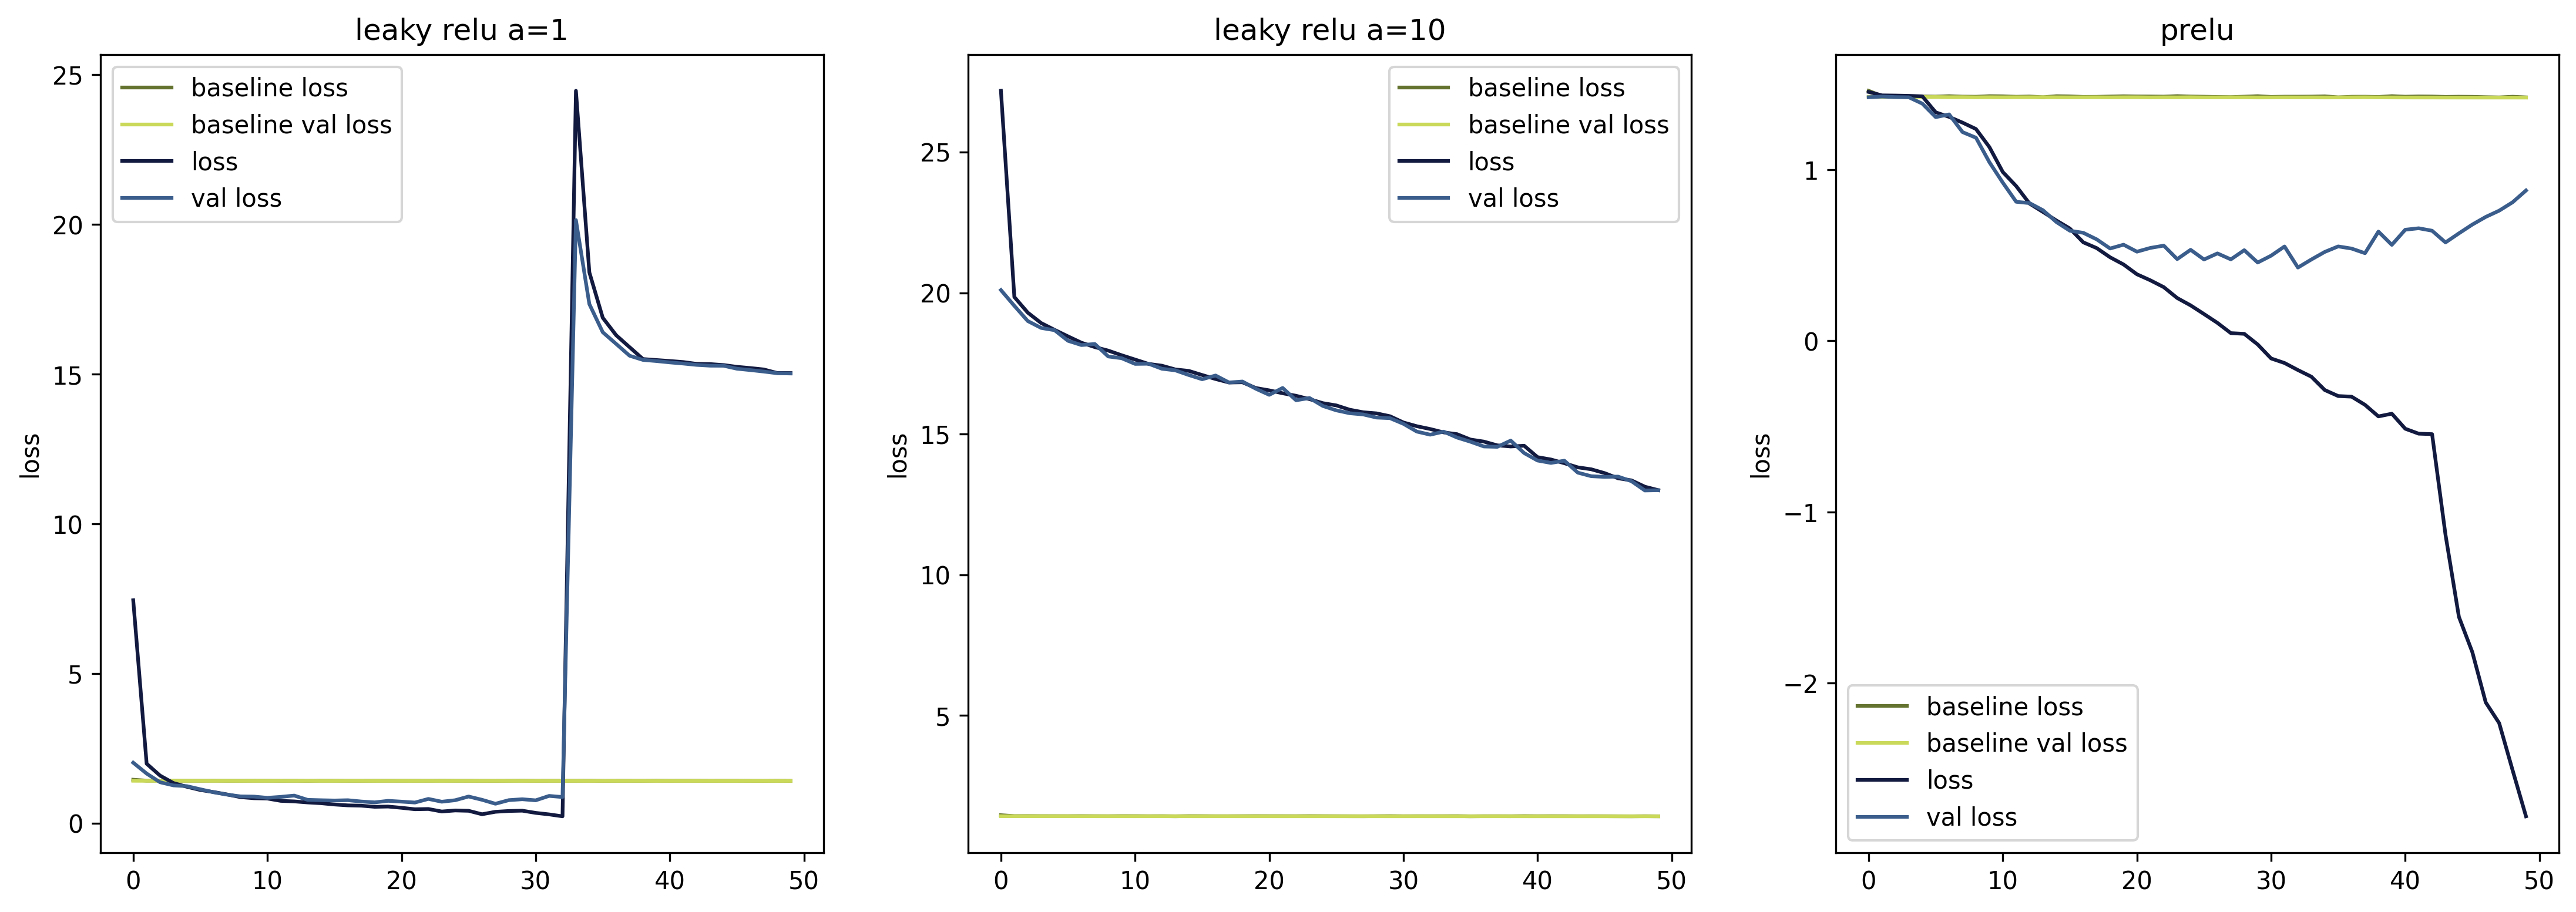

In [56]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=[18, 6], dpi=300)
act = ['leaky relu a=1', 'leaky relu a=10', 'prelu']

for i in range(3):
    sns.lineplot(x=range(len(ds_3_history_r)), y=np.log(ds_3_history_r.loss), ax=axes[i], color='#64732F', label='baseline loss')
    sns.lineplot(x=range(len(ds_3_history_r)), y=np.log(ds_3_history_r.val_loss), ax=axes[i], color='#CAD959', label='baseline val loss')
    sns.lineplot(x=range(len(ds3[i])), y=np.log(ds3[i].loss), ax=axes[i], color='#131A40', label='loss')
    sns.lineplot(x=range(len(ds3[i])), y=np.log(ds3[i].val_loss), ax=axes[i], color='#3A5D8C', label='val loss')
    axes[i].set_title(act[i])

plt.savefig('../../images/activation/emperical evaluation/ds_3_activation_eval.jpg')
plt.show()

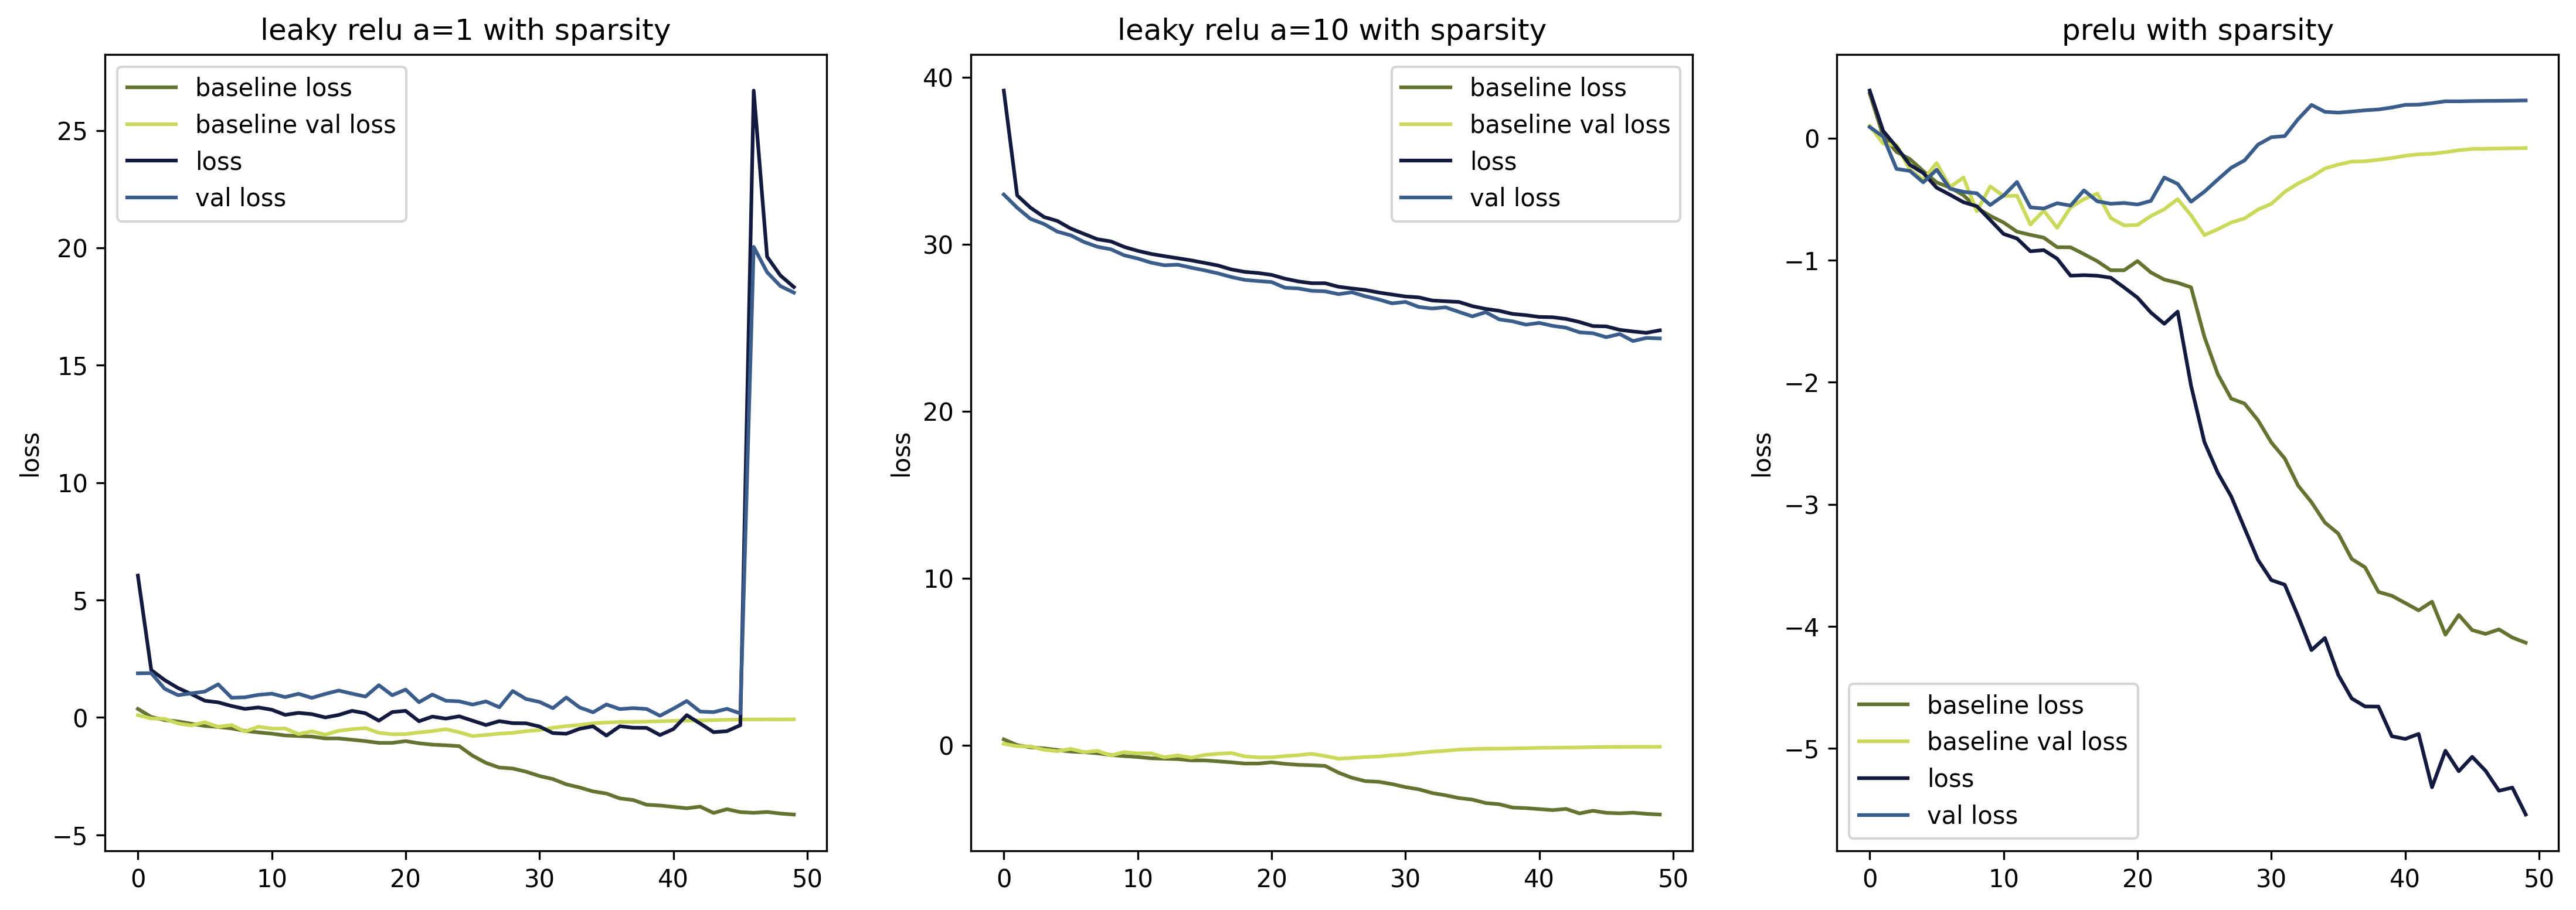

In [53]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=[18, 6], dpi=300)
act = ['leaky relu a=1 with sparsity', 'leaky relu a=10 with sparsity', 'prelu with sparsity']
ds1_dw = [ds_1_history_dw_lr1, ds_1_history_dw_lr2, ds_1_history_dw_pr]
ds2_dw = [ds_2_history_dw_lr1, ds_2_history_dw_lr2, ds_2_history_dw_pr]
ds3_dw = [ds_3_history_dw_lr1, ds_3_history_dw_lr2, ds_3_history_dw_pr]

for i in range(3):
    sns.lineplot(x=range(len(ds_1_history_dw_r)), y=np.log(ds_1_history_dw_r.loss), ax=axes[i], color='#64732F', label='baseline loss')
    sns.lineplot(x=range(len(ds_1_history_dw_r)), y=np.log(ds_1_history_dw_r.val_loss), ax=axes[i], color='#CAD959', label='baseline val loss')
    sns.lineplot(x=range(len(ds1_dw[i])), y=np.log(ds1_dw[i].loss), ax=axes[i], color='#131A40', label='loss')
    sns.lineplot(x=range(len(ds1_dw[i])), y=np.log(ds1_dw[i].val_loss), ax=axes[i], color='#3A5D8C', label='val loss')
    axes[i].set_title(act[i])

plt.savefig('../../images/activation/emperical evaluation/ds_dw_1_activation_eval.jpg')
plt.show()

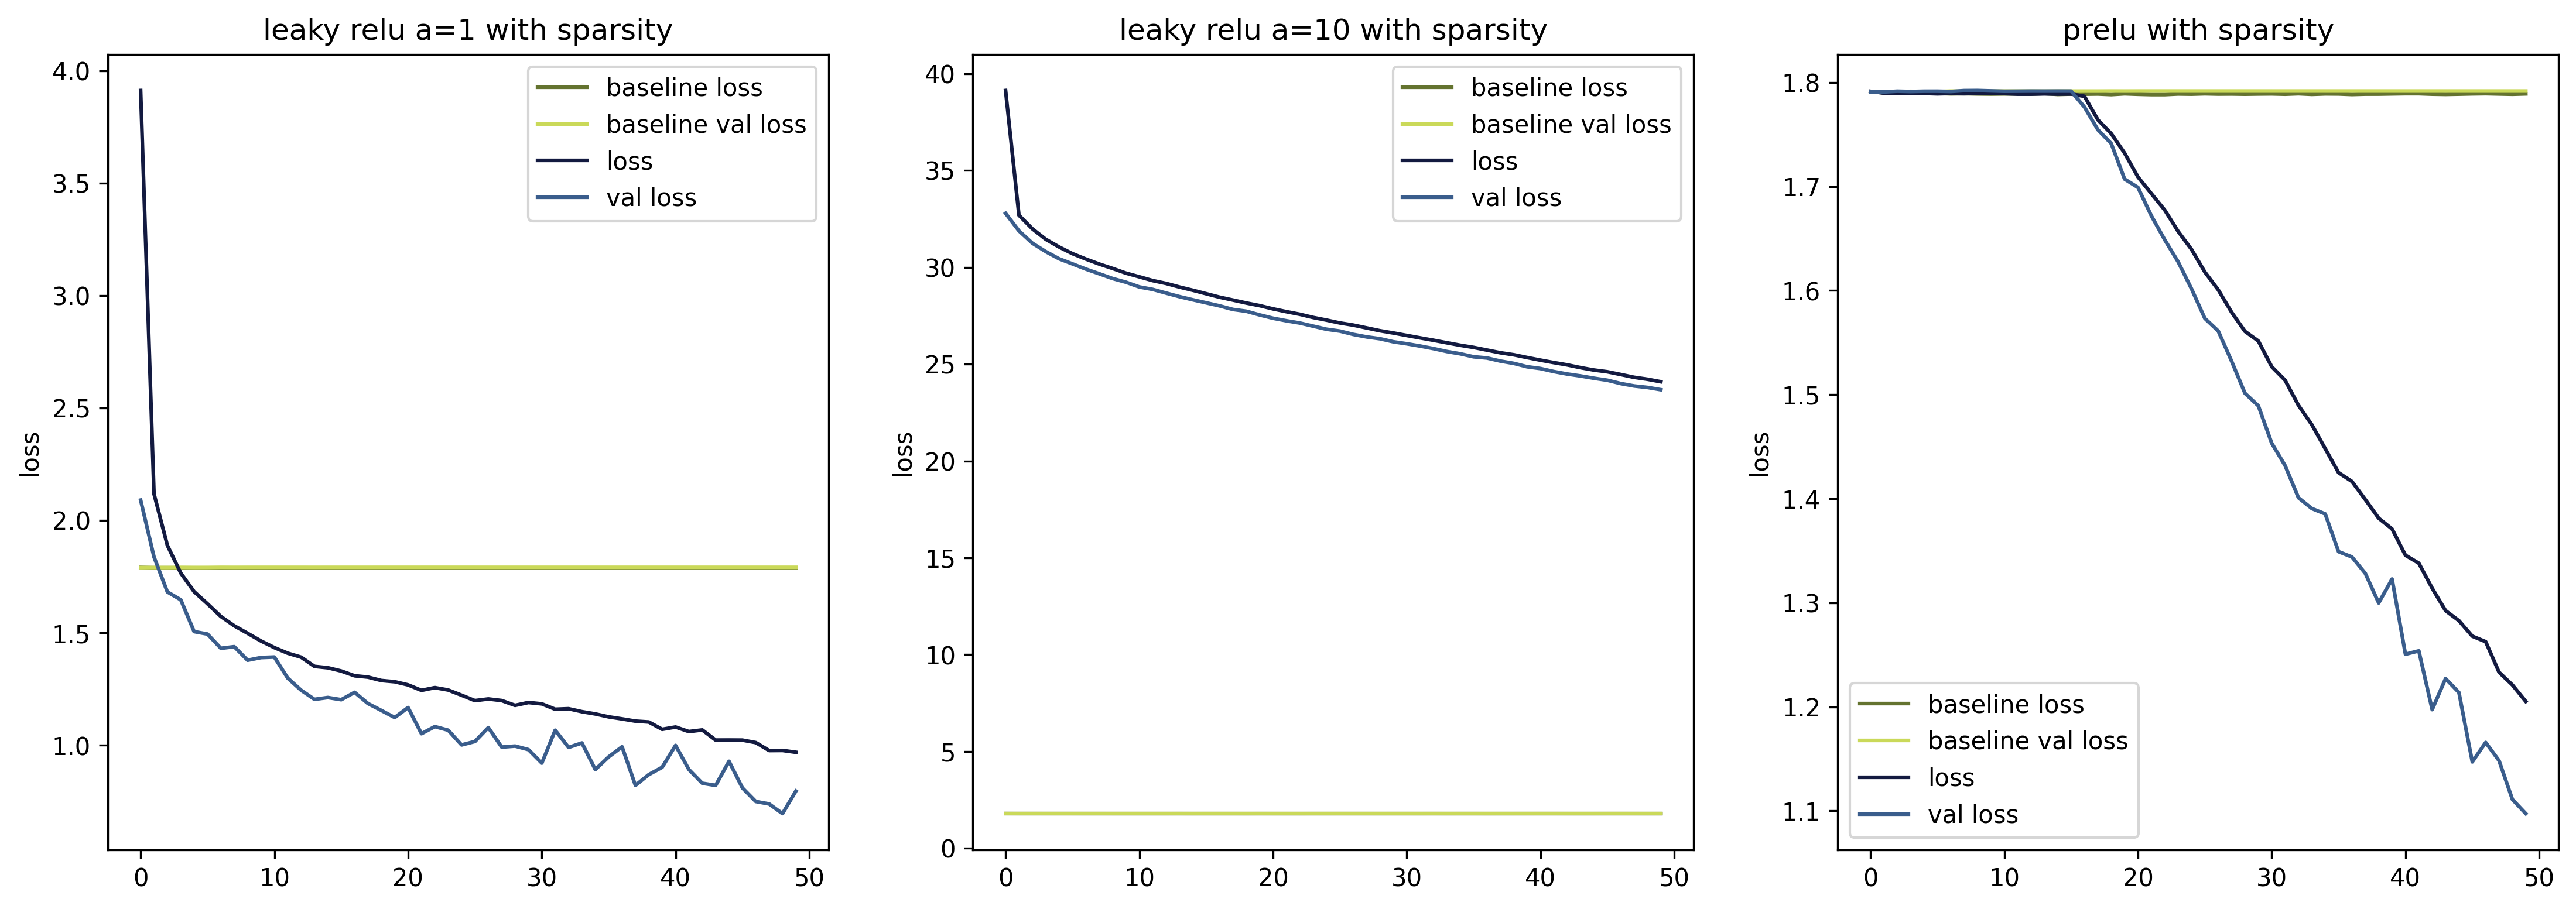

In [55]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=[18, 6], dpi=300)
act = ['leaky relu a=1 with sparsity', 'leaky relu a=10 with sparsity', 'prelu with sparsity']

for i in range(3):
    sns.lineplot(x=range(len(ds_2_history_dw_r)), y=np.log(ds_2_history_dw_r.loss), ax=axes[i], color='#64732F', label='baseline loss')
    sns.lineplot(x=range(len(ds_2_history_dw_r)), y=np.log(ds_2_history_dw_r.val_loss), ax=axes[i], color='#CAD959', label='baseline val loss')
    sns.lineplot(x=range(len(ds2_dw[i])), y=np.log(ds2_dw[i].loss), ax=axes[i], color='#131A40', label='loss')
    sns.lineplot(x=range(len(ds2_dw[i])), y=np.log(ds2_dw[i].val_loss), ax=axes[i], color='#3A5D8C', label='val loss')
    axes[i].set_title(act[i])

plt.savefig('../../images/activation/emperical evaluation/ds_dw_2_activation_eval.jpg')
plt.show()

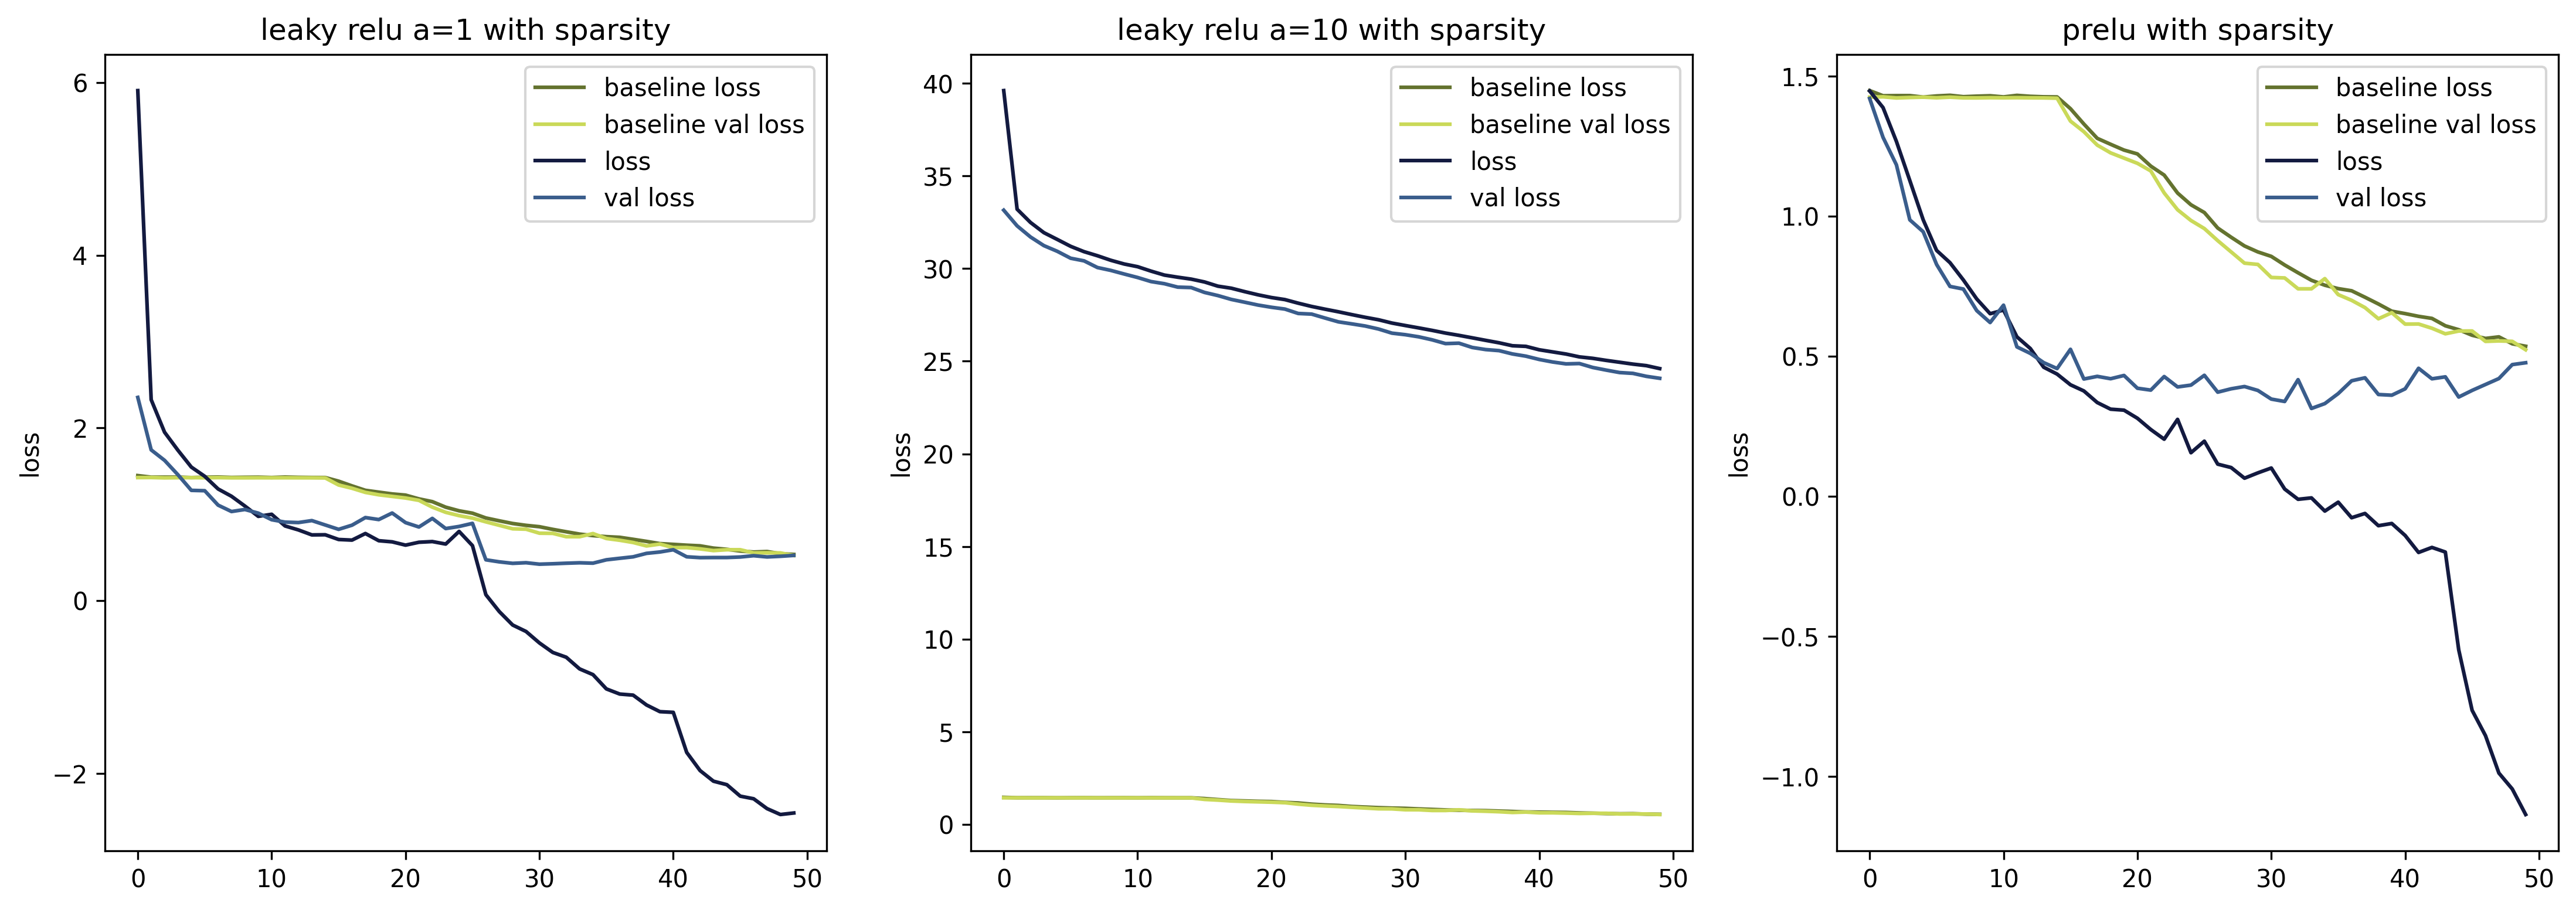

In [57]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=[18, 6], dpi=300)
act = ['leaky relu a=1 with sparsity', 'leaky relu a=10 with sparsity', 'prelu with sparsity']

for i in range(3):
    sns.lineplot(x=range(len(ds_3_history_dw_r)), y=np.log(ds_3_history_dw_r.loss), ax=axes[i], color='#64732F', label='baseline loss')
    sns.lineplot(x=range(len(ds_3_history_dw_r)), y=np.log(ds_3_history_dw_r.val_loss), ax=axes[i], color='#CAD959', label='baseline val loss')
    sns.lineplot(x=range(len(ds3_dw[i])), y=np.log(ds3_dw[i].loss), ax=axes[i], color='#131A40', label='loss')
    sns.lineplot(x=range(len(ds3_dw[i])), y=np.log(ds3_dw[i].val_loss), ax=axes[i], color='#3A5D8C', label='val loss')
    axes[i].set_title(act[i])

plt.savefig('../../images/activation/emperical evaluation/ds_dw_3_activation_eval.jpg')
plt.show()